In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import random
import os
from torch.autograd import Variable 
from torchvision import transforms
from data_loader import VistDataset
from build_vocab import Vocabulary
from model import EncoderStory, DecoderStory
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from disp_multiple_images import show_images
%matplotlib inline

In [2]:
def transform_image(image, transform=None):
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [3]:
#configuration
image_dir = './data/images/test'
sis_path = './data/sis/test.story-in-sequence.json'
dii_path = './data/dii/test.description-in-isolation.json'
#encoder_path = './models/encoder-{}.pkl'.format(numep)
#decoder_path = './models/decoder-{}.pkl'.format(numep)
vocab_path = './models/vocab.pkl'

#num item
numitem=357

In [4]:
def inference_test(numep, numit):

    encoder_path = './models/encoder-{}.pkl'.format(numep)
    decoder_path = './models/decoder-{}.pkl'.format(numep)
    img_feature_size = 1024
    embed_size = 256
    hidden_size = 1024
    num_layers = 2

    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])

    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    vist = VistDataset(image_dir, sis_path, dii_path, vocab)
    
    #encoder decoder loading
    encoder = EncoderStory(img_feature_size, hidden_size, num_layers)
    decoder = DecoderStory(embed_size, hidden_size, vocab)

    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    encoder.eval()
    decoder.eval()

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()
    
    #visualize images and photos 
    images, targets, photo_sequences, album_ids, gift = vist.GetItem(numit)

    image_tensor = []
    for image in images:
        image = transform_image(image, transform)
        image_tensor.append(image)

    image_tensor = torch.stack(image_tensor).squeeze(1).unsqueeze(0)
    #GetItem() with torch.stack() routine is exactly the same as __getitem__() method of data_loader.py
    
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    feature, hidden = encoder(image_tensor)
    inference_results = decoder.inference(feature.squeeze(0))

    sentences = []
    target_sentences = []
    descriptions = []

    for i, result in enumerate(inference_results):
        words = []
        for word_id in result:
            word = vocab.idx2word[word_id.cpu().item()]
            words.append(word)
            if word == '<end>':
                break

        words.remove('<start>')
        try:
            words.remove('<end>')
        except Exception:
            pass

        sentences.append(' '.join(words))

    for i, target in enumerate(targets):
        words = []
        target = target.numpy()
        for word_id in target:
            word = vocab.idx2word[word_id]
            words.append(word)
            if word == '<end>':
                break

        words.remove('<start>')
        try:
            words.remove('<end>')
        except Exception:
            pass
        target_sentences.append(' '.join(words))

    print("item:{y} ep:{n}".format(y=numit, n=numep) , sentences)
    #print(target_sentences)

['The family was awaiting, it was the first day of school all over again...', 'But, it was a special day for one of the children...', "It was Tara's first day of school EVER!", 'She was nervous and biting her nails...', 'But, when the bus arrived, she jumped on and was off to kindergarten. ']
['three kids and their dad sit on the couch and pose for picture .', 'two children stand in a driveway next to a car .', 'kissing her daughter bye , he will be leaving .', 'a girl sitting and relaxing on the couch with a stuffed animal .', 'school bus number 913 has children on board and a closed door .']


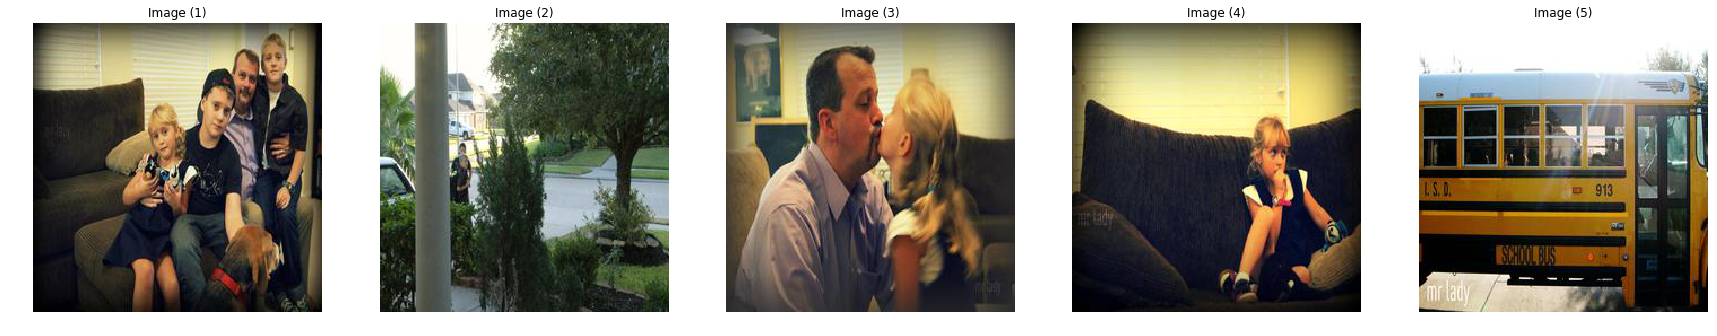

In [5]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

vist = VistDataset(image_dir, sis_path, dii_path, vocab)
images, targets, photo_sequences, album_ids, gift = vist.GetItem(numitem)
print(gift['ogGTs'])
print(gift['descs'])

imgs_show = [np.asarray(img) for img in images]
text_show = []
 
show_images(imgs_show)

In [6]:
for i in range(25,36):
    inference_test(i,numitem)

item:357 ep:25 ['the family was having a great time at the party .', 'the weather was very nice .', 'the kids were all happy .', 'the children were playing games .', 'the adults had a lot of fun .']
item:357 ep:26 ['the family was excited to be at the party .', 'they went outside and saw a beautiful view .', 'they took a picture with the bride and groom .', 'they also played some games .', 'they were happy to have a great time .']
item:357 ep:27 ['the girl was happy to be at the party .', 'the house was a little small .', 'the woman was smiling and having a good time .', 'the man was drinking and laughing .', 'the man was driving his car .']
item:357 ep:28 ['the family was happy to be together .', 'they were staying at a hotel .', 'they were very happy .', 'they had a great time .', 'they were all excited for the day .']
item:357 ep:29 ['the family was excited for the day .', 'the first day of the trip was the big drive .', 'they met up with some friends .', 'they had a great time .', 

# METEOR Eval

## References
* https://github.com/windx0303/VIST-Challenge-NAACL-2018